<a href="https://colab.research.google.com/github/Arun07062000/Deep-Audio-Classification/blob/main/Deep_Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Dependencies**

In [ ]:
!pip install tensorflow-io tensorflow

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf

In [ ]:
# EXAMPLE AUDIO PATH
caputan_file = '/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Parsed_Capuchinbird_Clips/XC114131-0.wav'
not_caputan_file = '/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav'

## **Building Data Loading Function**

In [ ]:

def load_wave_16k_mono(filename):
  # Load encoded wav file
  file_contents = tf.io.read_file(filename)
  # Decode wav(tensors by channel)
  wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels = 1)
  # Remove trailing axis
  wav = tf.squeeze(wav,axis=-1)
  sample_rate = tf.cast(sample_rate , dtype = tf.int64)
  # Goes from 44100hz to 16000hz - amplitude of the audio signal
  wav = tfio.audio.resample(wav,rate_in = sample_rate , rate_out = 16000)
  return wav


## **Plotting Wave**

In [ ]:
wave = load_wave_16k_mono(caputan_file)
nwav = load_wave_16k_mono(not_caputan_file)

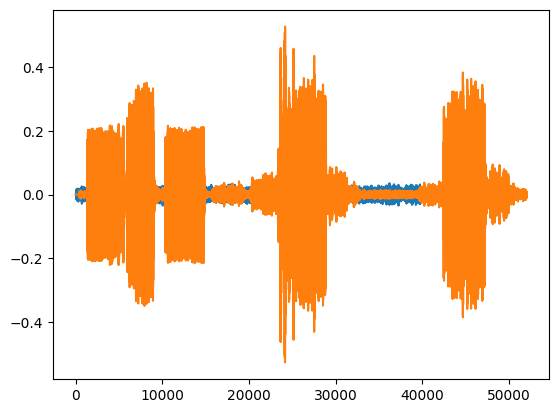

In [ ]:
plt.plot(wave)
plt.plot(nwav)
plt.show()

## **Creating Tensorflow Dataset**

In [ ]:
# Define Paths to Positive and Negative Data.
POS = '/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Parsed_Capuchinbird_Clips'
NEG = '/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Parsed_Not_Capuchinbird_Clips'

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
# Add labels and Combine Positive and Negative Samples.
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
lengths = []
for file in os.listdir('/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wave_16k_mono(os.path.join('/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=53518>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=72000>

## **Build Preprocessing Function to Convert to Spectrogram**

In [ ]:
def preprocess(filepath,label):
  wav = load_wave_16k_mono(filepath)
  wav = wav[:48000] # we will take this length of wav call only
  zero_padding = tf.zeros([48000] - tf.shape(wav) , dtype = tf.float32)
  wav = tf.concat([zero_padding,wav],0)
  spectrogram = tf.signal.stft(wav,frame_length = 320,frame_step = 32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram , axis=2)
  return spectrogram,label

In [ ]:
filepath,label = positives.shuffle(10000).as_numpy_iterator().next()

In [ ]:
spectrogram,label = preprocess(filepath,label)

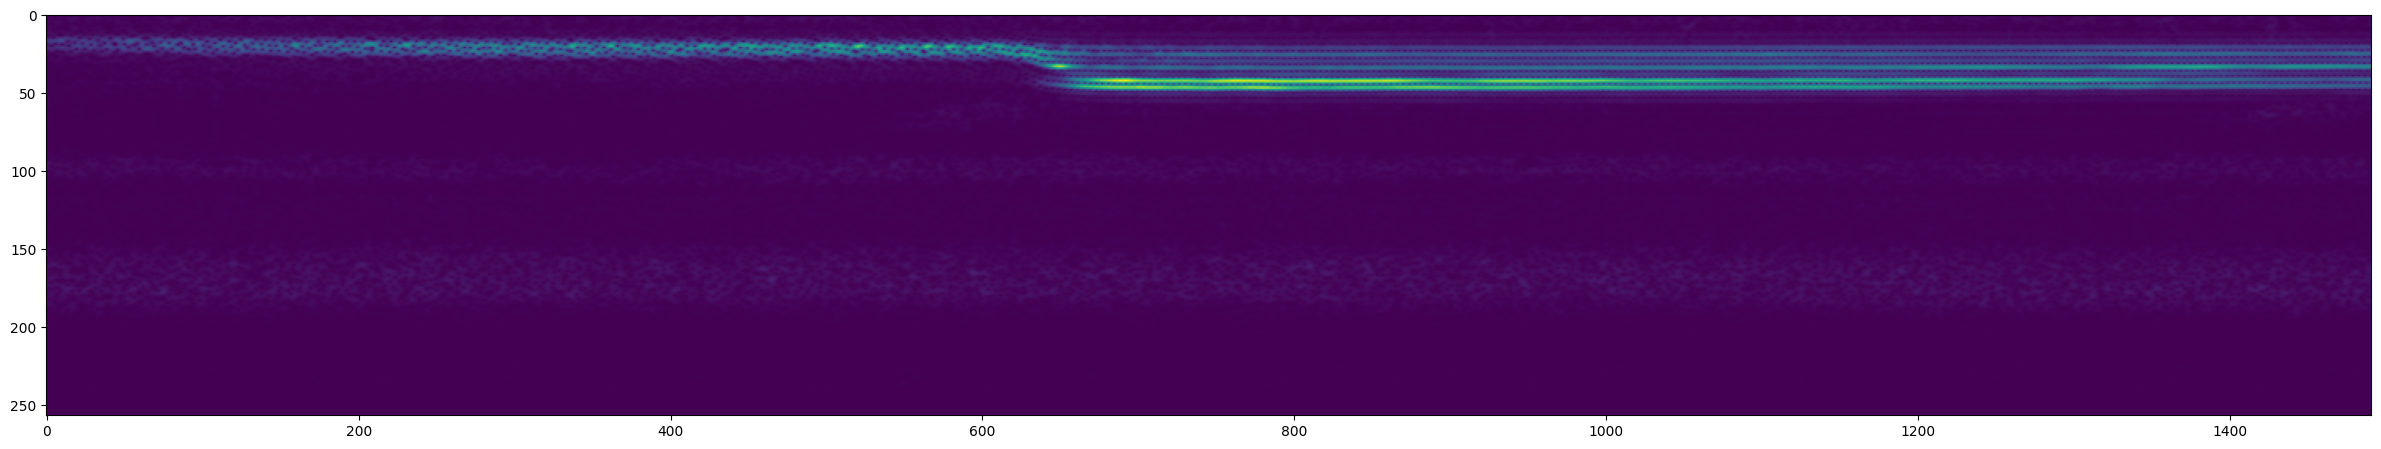

In [ ]:
# Plotting the spectrogram.
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## **Create Training and Testing Partitions**

In [ ]:
# Creating a TensorFlow Data Pipeline.
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(4)
data = data.prefetch(2)

In [ ]:
train = data.take(36)   # len(data)*.7
test = data.skip(36).take(15) # rest of the data as total len(data) is 51

In [ ]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(4, 1491, 257, 1)

## **Build Deep Learning Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , Flatten

In [ ]:
model  = Sequential()
model.add(Conv2D(10,(3,3),activation = 'relu',input_shape = (1491, 257, 1)))
model.add(Conv2D(10,(3,3),activation = 'relu'))
model.add(Flatten())
model.add(Dense(126, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model.compile('Adam',loss = 'BinaryCrossentropy',metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 10)     100       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 10)     910       
                                                                 
 flatten (Flatten)           (None, 3762110)           0         
                                                                 
 dense (Dense)               (None, 126)               474025986 
                                                                 
 dense_1 (Dense)             (None, 1)                 127       
                                                                 
Total params: 474027123 (1.77 GB)
Trainable params: 474027123 (1.77 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Fit Model, View Loss and KPI Plots**

In [ ]:
hist = model.fit(train , epochs = 8 , validation_data = test)

Epoch 1/8
36/36 [==============================] - 5s 133ms/step - loss: 0.0412 - recall_2: 0.9773 - precision_2: 0.9773 - val_loss: 0.0225 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 2/8
36/36 [==============================] - 5s 130ms/step - loss: 0.0239 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0167 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 3/8
36/36 [==============================] - 5s 131ms/step - loss: 0.0119 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0158 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 4/8
36/36 [==============================] - 5s 134ms/step - loss: 0.0163 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0173 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 5/8
36/36 [==============================] - 5s 133ms/step - loss: 0.0138 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 0.0202 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 6/8
36/36 [==============================] - 5s 1

In [ ]:
model.save('AudioClassification.h5')

## **View Loss and KPI Plots**

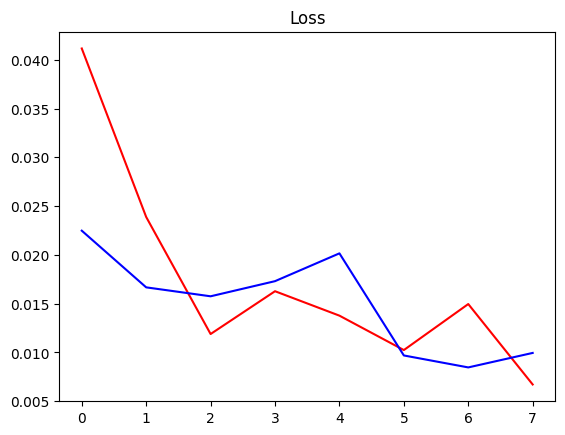

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

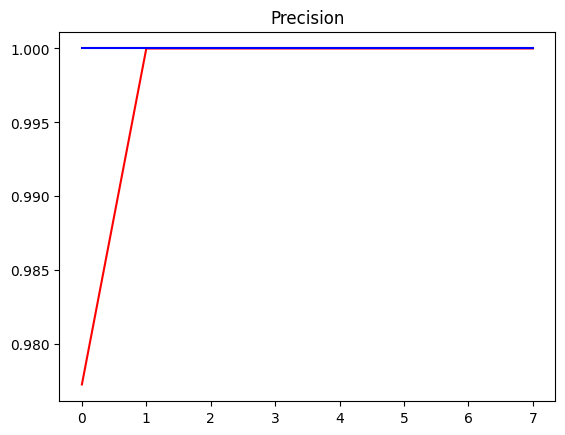

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_2'], 'r')
plt.plot(hist.history['val_precision_2'], 'b')
plt.show()

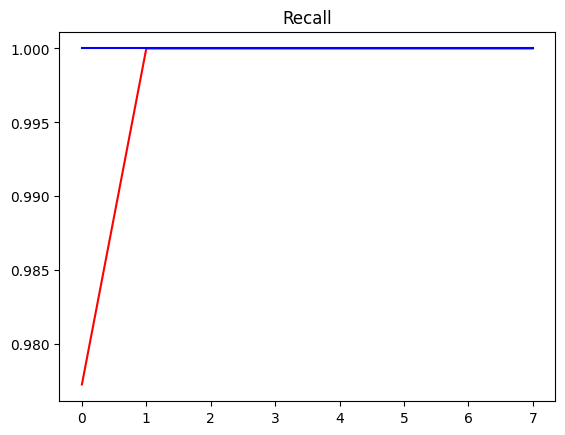

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
plt.plot(hist.history['val_recall_2'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 101ms/step


**Convert Logits to Classes**

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## **Build Forest Parsing Functions**

**Load Up Mp3**

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = '/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Forest Recordings/recording_00.mp3'
wav = load_mp3_16k_mono(mp3)

In [ ]:
# getting different slices of that longer clip (wav).
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

**Build Function to Convert Clips into Windowed Spectrograms**

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

**Convert Longer Clips into Windows and Make Predictions**

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 9s 2s/step


**Group Consecutive Detections**

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

7

## **Make Predictions**

**Loop over all recordings and make predictions**

In [ ]:
results = {}
for file in os.listdir('/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Forest Recordings'):
    FILEPATH = os.path.join('/content/drive/MyDrive/data for DL and ML/Kapoochan Bird Audio Data/Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [ ]:
results

**Convert Predictions into Classes**

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

**Group Consecutive Detections(Bird Call)**

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_02.mp3': 0,
 'recording_05.mp3': 0,
 'recording_03.mp3': 0,
 'recording_08.mp3': 24,
 'recording_01.mp3': 0,
 'recording_06.mp3': 5,
 'recording_04.mp3': 4,
 'recording_07.mp3': 2,
 'recording_13.mp3': 0,
 'recording_15.mp3': 1,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_12.mp3': 0,
 'recording_11.mp3': 5,
 'recording_14.mp3': 0,
 'recording_19.mp3': 0,
 'recording_18.mp3': 6,
 'recording_23.mp3': 7,
 'recording_21.mp3': 1,
 'recording_24.mp3': 0,
 'recording_17.mp3': 5,
 'recording_22.mp3': 2,
 'recording_16.mp3': 7,
 'recording_20.mp3': 0,
 'recording_26.mp3': 2,
 'recording_32.mp3': 2,
 'recording_25.mp3': 1,
 'recording_30.mp3': 1,
 'recording_28.mp3': 4,
 'recording_31.mp3': 1,
 'recording_29.mp3': 15,
 'recording_27.mp3': 0,
 'recording_33.mp3': 0,
 'recording_37.mp3': 6,
 'recording_36.mp3': 0,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_39.mp3': 1,
 'recording_38.mp3': 2,
 'recording_40.mp3': 1,
 'recording_41

## **Export Results**

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])